In [1]:
from model.test import test
from utils import get_opt

from htr import get_page_dataset
import matplotlib.pyplot as plt
import os
import cv2

/Users/anastasiabogatenkova/miniconda3/envs/doc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/anastasiabogatenkova/miniconda3/envs/doc/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
def show_results(doc_path):
    dataset_path = get_page_dataset(os.path.join("data", doc_path), "result")
    opt = get_opt(eval_data=dataset_path, saved_model="iter_300000.pth")
    word_list = test(opt)
    axes_x = 3
    axes_y = min(len(word_list) // 3, 6)
    len_axes = axes_x * axes_y
    fig, axes = plt.subplots(axes_y, axes_x)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    for i, word in enumerate(word_list):
        if i >= len_axes:
            break
        img_name = f"result/data/{i:03d}.png"
        im = cv2.imread(img_name)
        axes[i//3,i%3].set_title(f"predicted: {word}")
        axes[i//3,i%3].imshow(im)
        axes[i//3,i%3].axis('off')


model input parameters 32 100 20 1 512 256 160 25 TPS ResNet BiLSTM Attn
loading pretrained model from iter_300000.pth
dataset_root:    result/dataset	 dataset: /
sub-directory:	/.	 num samples: 94


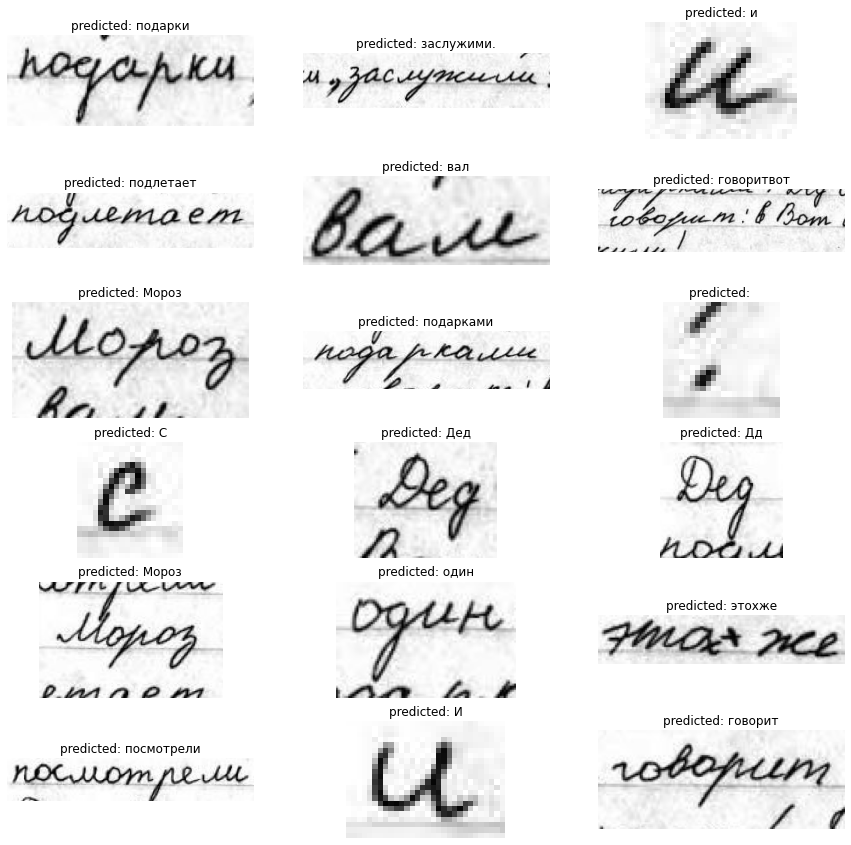

In [8]:
show_results("3.jpg")

model input parameters 32 100 20 1 512 256 160 25 TPS ResNet BiLSTM Attn
loading pretrained model from iter_300000.pth
dataset_root:    result/dataset	 dataset: /
sub-directory:	/.	 num samples: 104


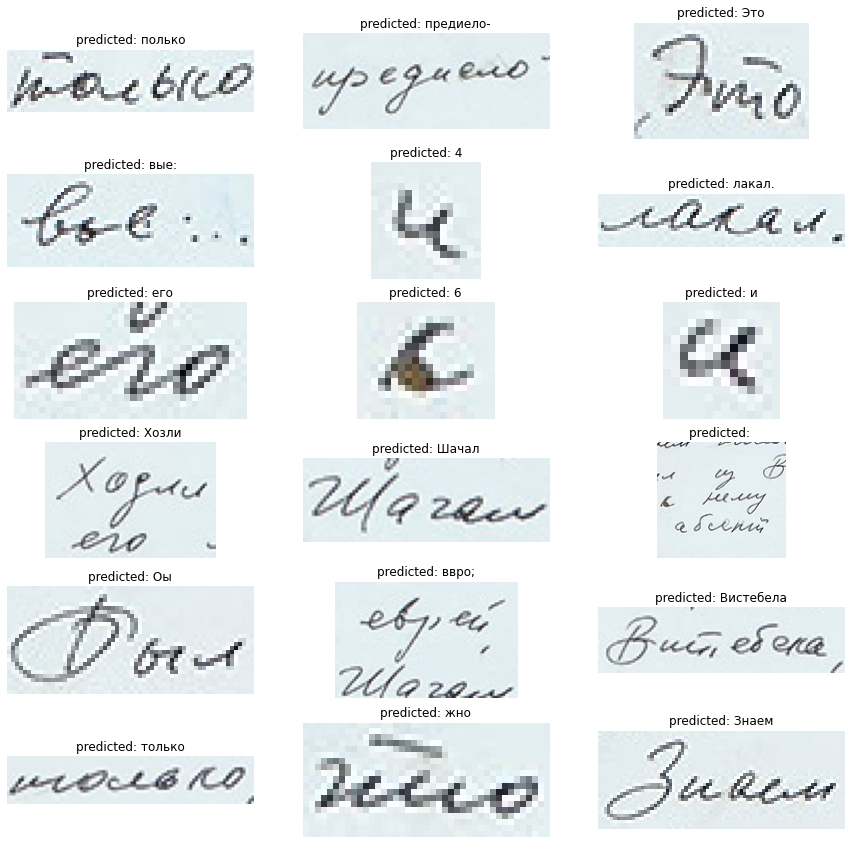

In [9]:
show_results("1.jpg")

model input parameters 32 100 20 1 512 256 160 25 TPS ResNet BiLSTM Attn
loading pretrained model from iter_300000.pth
dataset_root:    result/dataset	 dataset: /
sub-directory:	/.	 num samples: 38


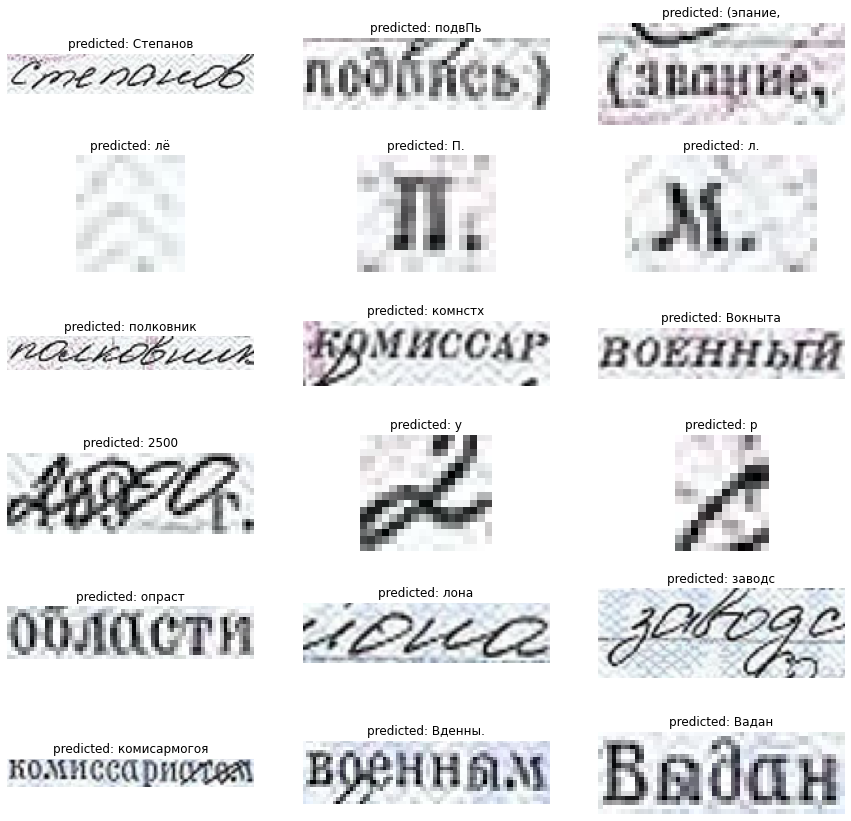

In [10]:
show_results("2.jpg")

In [1]:
from PIL import Image
import torch
from model.dataset import AlignCollate

/Users/anastasiabogatenkova/miniconda3/envs/doc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_max_length = 25
length_for_pred = torch.IntTensor([batch_max_length] * 1).to(device)
text_for_pred = torch.LongTensor(1, batch_max_length + 1).fill_(0).to(device)

In [64]:
img = Image.open("data/2.jpg").convert('L')

In [65]:
img.height, img.width

(674, 477)

In [66]:
from utils import get_opt

opt = get_opt("", "best_accuracy.pth")

In [67]:
from model.model import Model

opt.input_channel = 1
opt.num_class = 160
opt.batch_size = 1
model = Model(opt)
model = torch.nn.DataParallel(model).to(device)
model.load_state_dict(torch.load(opt.saved_model, map_location=device))
model.eval()

1

1

In [68]:
converter = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD)

img_tensor, label_tensor = converter([(img, text_for_pred)])
img_tensor.shape, label_tensor[0].shape

(torch.Size([1, 1, 32, 100]), torch.Size([1, 26]))

In [71]:
preds = model(img_tensor, text_for_pred, is_train=False)

In [73]:
from model.utils import AttnLabelConverter

preds_size = torch.IntTensor([preds.size(1)] * 1)
_, preds_index = preds.max(2)
converter = AttnLabelConverter(opt.character)
preds_str = converter.decode(preds_index.data, preds_size.data)

In [77]:
for pred in preds_str:
    print(pred[:pred.find('[s]')])

Ие
